/tmp/ipykernel_1092509/4062400486.py:40: RuntimeWarning: divide by zero encountered in scalar divide
  return (1 / np.sqrt(2 * np.pi * var)) * np.exp(-0.5 * ((X - mean) ** 2) / var)
/tmp/ipykernel_1092509/4062400486.py:40: RuntimeWarning: divide by zero encountered in divide
  return (1 / np.sqrt(2 * np.pi * var)) * np.exp(-0.5 * ((X - mean) ** 2) / var)
/tmp/ipykernel_1092509/4062400486.py:40: RuntimeWarning: invalid value encountered in divide
  return (1 / np.sqrt(2 * np.pi * var)) * np.exp(-0.5 * ((X - mean) ** 2) / var)
/tmp/ipykernel_1092509/4062400486.py:40: RuntimeWarning: invalid value encountered in multiply
  return (1 / np.sqrt(2 * np.pi * var)) * np.exp(-0.5 * ((X - mean) ** 2) / var)


Segmentation Accuracy: 0.8014


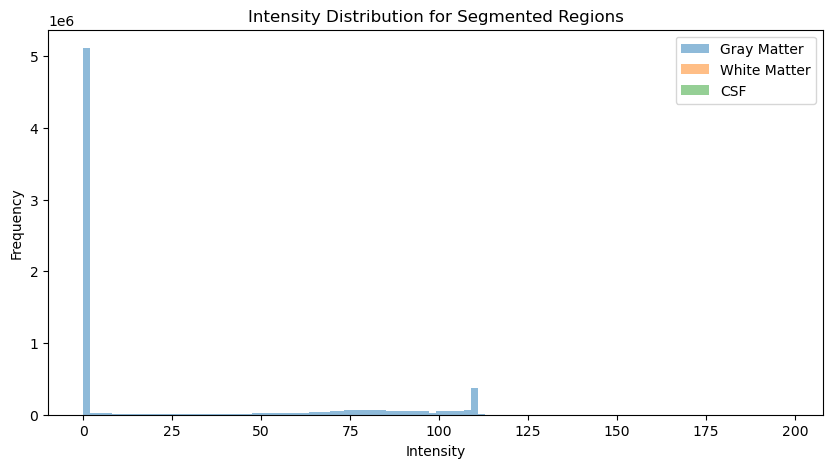

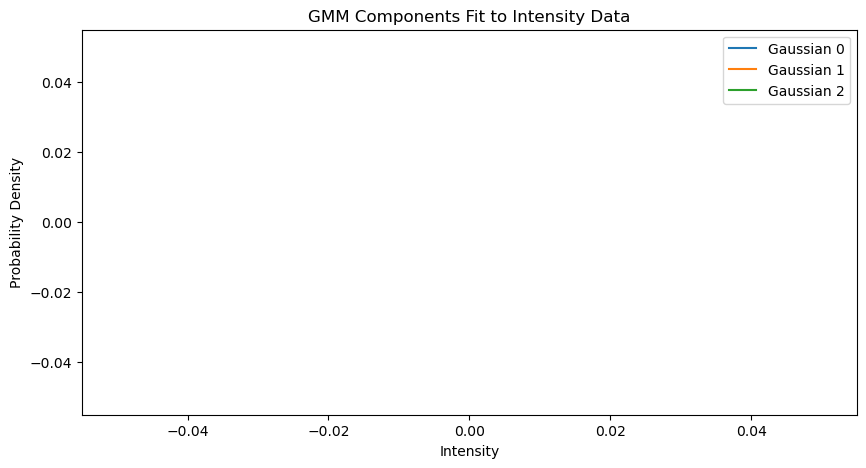

ValueError: Image data has type int64, which may cause incompatibilities with other tools. To use this type, pass an explicit header or dtype argument to Nifti1Image().

In [10]:
import numpy as np
import nibabel as nib
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score

def load_nifti_image(file_path):
    img = nib.load(file_path)
    data = img.get_fdata()
    return data

# Load the MRI image
image_path = "data/sald_031764_img.nii"
mri_image = load_nifti_image(image_path)

# Load ground truth probability masks (modify paths accordingly)
gm_mask = load_nifti_image("data/sald_031764_probmask_graymatter.nii")
wm_mask = load_nifti_image("data/sald_031764_probmask_whitematter.nii")
csf_mask = load_nifti_image("data/sald_031764_probmask_csf.nii")

# Flatten the image and masks
image_flat = mri_image.flatten()
gm_flat = gm_mask.flatten()
wm_flat = wm_mask.flatten()
csf_flat = csf_mask.flatten()

class GaussianMixtureModel:
    def __init__(self, n_components=3, max_iter=100, tol=1e-4):
        self.n_components = n_components
        self.max_iter = max_iter
        self.tol = tol

    def initialize_parameters(self, X):
        """Initialize means, variances, and mixing coefficients randomly"""
        self.means = np.random.choice(X, self.n_components)
        self.variances = np.full(self.n_components, np.var(X))
        self.weights = np.full(self.n_components, 1 / self.n_components)

    def gaussian(self, X, mean, var):
        """Compute Gaussian probability density function"""
        return (1 / np.sqrt(2 * np.pi * var)) * np.exp(-0.5 * ((X - mean) ** 2) / var)

    def expectation_step(self, X):
        """E-Step: Compute responsibilities"""
        responsibilities = np.zeros((X.shape[0], self.n_components))

        for k in range(self.n_components):
            responsibilities[:, k] = self.weights[k] * self.gaussian(X, self.means[k], self.variances[k])

        # Normalize responsibilities
        responsibilities /= responsibilities.sum(axis=1, keepdims=True)
        return responsibilities

    def maximization_step(self, X, responsibilities):
        """M-Step: Update means, variances, and mixing coefficients"""
        Nk = responsibilities.sum(axis=0)
        
        self.weights = Nk / X.shape[0]
        self.means = (responsibilities.T @ X) / Nk
        self.variances = (responsibilities.T @ (X ** 2)) / Nk - self.means ** 2

    def fit(self, X):
        """Train GMM using Expectation-Maximization"""
        self.initialize_parameters(X)
        
        for _ in range(self.max_iter):
            old_means = self.means.copy()
            
            responsibilities = self.expectation_step(X)
            self.maximization_step(X, responsibilities)
            
            # Check convergence
            if np.linalg.norm(self.means - old_means) < self.tol:
                break

    def predict(self, X):
        """Assign each point to the most probable Gaussian component"""
        responsibilities = self.expectation_step(X)
        return np.argmax(responsibilities, axis=1)

# Train GMM on the MRI image intensity values
gmm = GaussianMixtureModel(n_components=3)
gmm.fit(image_flat)

# Get segmentation labels
segmentation_labels = gmm.predict(image_flat)

# Create ground truth labels
ground_truth = np.zeros_like(segmentation_labels)
ground_truth[gm_flat > wm_flat] = 0  # Gray Matter
ground_truth[wm_flat > gm_flat] = 1  # White Matter
ground_truth[csf_flat > wm_flat] = 2  # CSF

# Compute accuracy
accuracy = accuracy_score(ground_truth, segmentation_labels)
print(f"Segmentation Accuracy: {accuracy:.4f}")

plt.figure(figsize=(10, 5))
plt.hist(image_flat[segmentation_labels == 0], bins=100, alpha=0.5, label="Gray Matter")
plt.hist(image_flat[segmentation_labels == 1], bins=100, alpha=0.5, label="White Matter")
plt.hist(image_flat[segmentation_labels == 2], bins=100, alpha=0.5, label="CSF")
plt.xlabel("Intensity")
plt.ylabel("Frequency")
plt.legend()
plt.title("Intensity Distribution for Segmented Regions")
plt.show()

x_vals = np.linspace(np.min(image_flat), np.max(image_flat), 500)
gmm_distributions = np.zeros((3, len(x_vals)))

for k in range(3):
    gmm_distributions[k] = gmm.weights[k] * gmm.gaussian(x_vals, gmm.means[k], gmm.variances[k])

plt.figure(figsize=(10, 5))
for k in range(3):
    plt.plot(x_vals, gmm_distributions[k], label=f'Gaussian {k}')
plt.xlabel("Intensity")
plt.ylabel("Probability Density")
plt.legend()
plt.title("GMM Components Fit to Intensity Data")
plt.show()

# Reshape segmentation back to original image shape
segmentation_image = segmentation_labels.reshape(mri_image.shape)

# Save as NIfTI for ITK-SNAP visualization
seg_img = nib.Nifti1Image(segmentation_image, affine=nib.load(image_path).affine)
nib.save(seg_img, "segmentation_result.nii")

print("Segmentation saved as segmentation_result.nii. Open it in ITK-SNAP.")



In [14]:
image_flat[segmentation_labels == 2]

array([], dtype=float64)

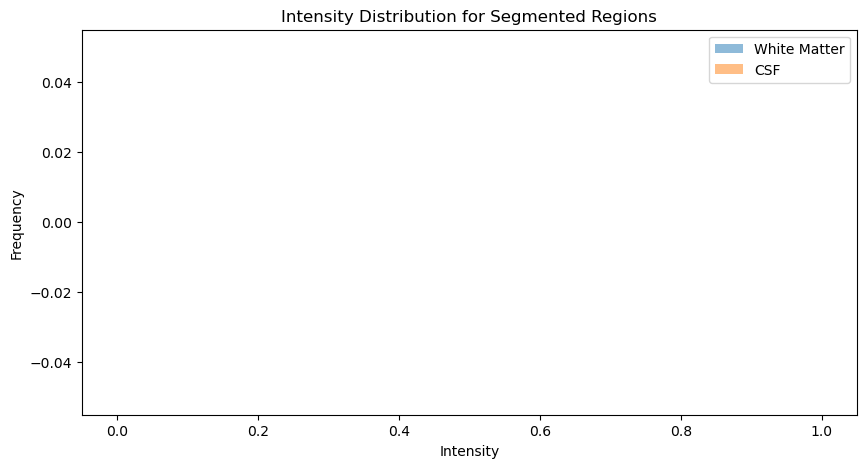

In [11]:
plt.figure(figsize=(10, 5))
# plt.hist(image_flat[segmentation_labels == 0], bins=100, alpha=0.5, label="Gray Matter")
plt.hist(image_flat[segmentation_labels == 1], bins=100, alpha=0.5, label="White Matter")
plt.hist(image_flat[segmentation_labels == 2], bins=100, alpha=0.5, label="CSF")
plt.xlabel("Intensity")
plt.ylabel("Frequency")
plt.legend()
plt.title("Intensity Distribution for Segmented Regions")
plt.show()